# 🗓 Section 23 - Pt2: Cost Functions, and Gradient Descent

- online-ds-ft-070620
- 09/16/20

## Learning Objectives

- Review how we can use derivatives to find minima/maxima
- Introduce the terminology of Cost/Loss functions
- Attempt to guess a linear regression model on our own using derivatives, but without gradient descent.
- Learn what gradient descent is and what step sizes are.
- **Activity: Step Sizes Lab.**
- Define what a gradient really is in multiple dimensions.
- Demonstrate Gradient Descent using a Linear Regression model with Residual Sum of Squares.
- **Activity: Applying Gradient Descent Lab**

## Questions?

https://docs.google.com/document/d/1FJ6rvuq4n-FUuYa60kCgXzT-x6wvYi3VlwVlwwcUY7w/edit?usp=sharing

## Previously on...


### Using Derivatives to Find the Minimum of Function

In [1]:
from fsds.imports import *

fsds v0.2.23 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
## https://learn.co/tracks/module-3-data-science-career-2-1/machine-learning/section-23-calculus/derivatives-conclusion
from derivatives import *

In [3]:
import numpy as np
tuple_sq_pos  = np.array([[2, 2], [-8, 1]])
x_values = np.linspace(-6, 10, 100)
function_values = list(map(lambda x: output_at(tuple_sq_pos, x), x_values))
derivative_values = list(map(lambda x: derivative_at(tuple_sq_pos, x),x_values))

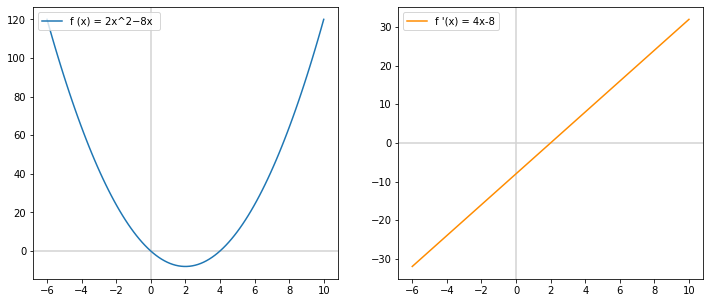

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,5))

# plot 1
plt.subplot(121)
plt.axhline(y=0, color='lightgrey', )
plt.axvline(x=0, color='lightgrey')
plt.plot(x_values, function_values, label = "f (x) = 2x^2−8x ")

plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=2, fancybox=True)

# plot 2
plt.subplot(122)
plt.axhline(y=0, color='lightgrey')
plt.axvline(x=0, color='lightgrey')
plt.plot(x_values, derivative_values,color="darkorange", label = "f '(x) = 4x-8")

ax.grid(True, which='both')

plt.legend(loc="upper left");

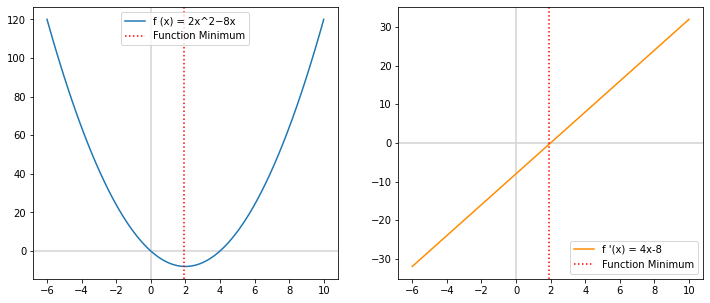

In [5]:
func_values_series = pd.Series(function_values,index=x_values)#.min()
deriv_values_series = pd.Series(derivative_values,index=x_values)

(ax1,ax2) = fig.get_axes()
ax1.axvline(func_values_series.idxmin(),
            ls=':',c='red',label='Function Minimum')
ax2.axvline(func_values_series.idxmin(),
            ls=':',c='red',label='Function Minimum')
[a.legend() for a in [ax1,ax2]]
fig

- The minimum of a function has an instanteous rate of change = 0
    - Therefore the value of x that produces a derivative=0 is the minimum of a function

>  This is fundamental concept behind gradient descent (which will discuss in-depth next study group), using derivatives with cost/loss functions to find the best values with the lowest error.


<img src="https://raw.githubusercontent.com/jirvingphd/dsc-gradient-descent-step-sizes-online-ds-ft-100719/master/images/snowboard.png" width=50%>

- **So how can we use this fact in Machine Learning?**
    - We can use the derivatives of our cost functions for our models to determine what parameters would be best for your model/

## Cost Functions 


> - A cost function is a function that calculates the error of our models predictions vs ground truth.
    - "Cost function" = "Loss function" = "Error"

- **Multiple notations/names:**

    - Loss Function: $L(y,t)$

    - Cost Function: $C(y,t)$

    - Error: $E(y,t)$
    


### Cost Functions You've Already Seen

- Error terms we used for linear regression back in Module 1 included Mean Squared Error and Root Mean Squared Error

#### Residual Sum of Squares

$ \large RSS = \sum_{i=1}^n(actual - expected)^2 = \sum_{i=1}^n(y_i - \hat{y})^2 $


#### Mean Squared Error

$ \large MSE = \frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat y_{i})^2$

- Note that MSE is just RSS divided by the number of data points. So its the *mean* of the residual sum of squares (AKA squared error)

#### Root Mean Squared Error
$ \large  RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat y_{i})^2}$
- Note that RMSE is just the square root of MSE.

## Intro to Gradient Descent Using Linear Regression

### Linear Regression Example

In [6]:
from fsds.imports import *

## Kaggle Dataset https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
url = "https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/datasets/house-prices-advanced-regression-techniques/train.csv"

df = pd.read_csv(url)
# display(df.head())
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
## convert target to $1000 of dollars
df['SalePrice ($K)']=df['SalePrice']/1000

X = df['GrLivArea'].copy()
y = df['SalePrice ($K)'].copy()

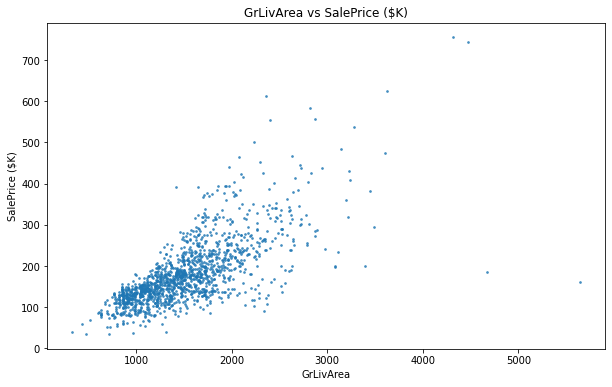

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(X, y, s=3,
          alpha=0.7, label="raw data")

ax.set(title=f"{X.name} vs {y.name}",
       ylabel=y.name,
       xlabel=X.name);


**in Linear Regression, we predict $y$ using 2 parameters, m (slope) + b(intercept/constant):**

$$ \large y = mx+b $$
where: 
    
- $x$ = input data for modeling
- $y$ = model predictions
- $m$ = slope
- $b$ = intercept


- Since our regression equation is our model, $y$ is really our model's prediction, which we represent as $\hat{y}$

$$ \large \hat{y} = mx+b $$


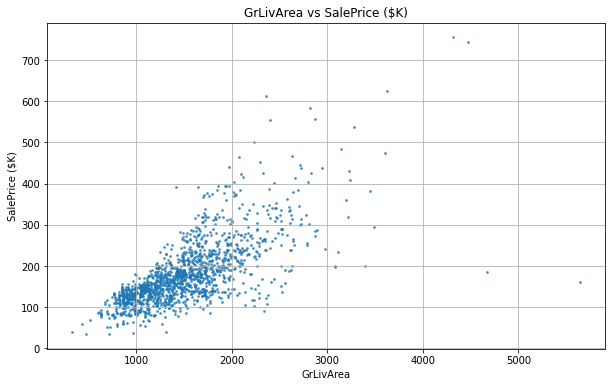

In [9]:
def scatter_plot(X,y):
    """Plots 2 pandas Series."""
    fig, ax = plt.subplots(figsize=(10,6))

    ax.scatter(X, y, s=3,
              alpha=0.7, label="raw data")

    ax.set(title=f"{X.name} vs {y.name}",
           ylabel=y.name,
           xlabel=X.name);
    return fig,ax
fig,ax = scatter_plot(X,y)
ax.grid()


### Activity: Let's Attempt to Guess Our Best-Fit Regression Line

- Pick an initial starting value for the slope and intercept (take a guess as to what they may be from examining the figure)

In [12]:
## guess slope:
slope = 
## guess intercept:
intercept = 

def regression_model(x,m,b):
    return m*x+b

def regression_formula(m,b):    
    formula = f"y = {round(m,2)}*x + {round(b,2)}"
    return formula

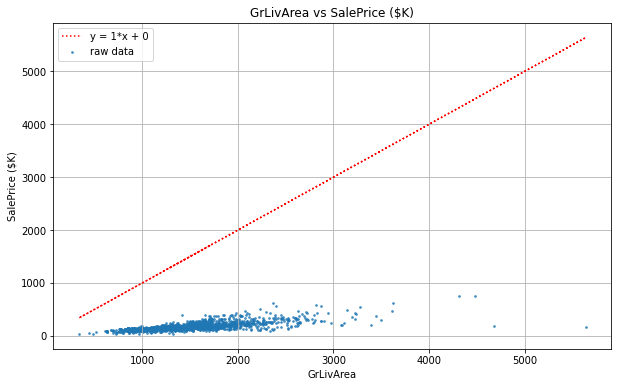

In [13]:
## Get Predictions from model
y_pred = regression_model(X,slope,intercept)

## Plot Raw Data
fig,ax = scatter_plot(X,y)

## Plot Predicted Values
ax.plot(X,y_pred,c='red',ls=':', label = regression_formula(slope,intercept))
ax.legend()
ax.grid()

### Let's Calculate our Models' Erorr/Cost using RSS

In [14]:
import math
from sklearn.metrics import r2_score

def errors(x_values, y_values, m, b):
    """(y_i - y_hat_i)"""
    y_line = regression_model(x_values,m,b)#(b + m*x_values)
    return (y_values - y_line)

def squared_errors(x_values, y_values, m, b):
    """(y_i - y_hat_i)**2"""
    err_squared = errors(x_values, y_values, m, b)**2
    return np.round(err_squared, 2)

def residual_sum_squares(x_values, y_values, m, b):
    """sum((y_i - y_hat_i)**2)"""
    rss =sum(squared_errors(x_values, y_values, m, b))
    return round(rss, 2)

def root_mean_squared_error(x_values, y_values, m, b):
    rmse = math.sqrt(sum(squared_errors(x_values, y_values, m, b)))/len(x_values)
    return round(rmse, 2)

In [15]:
## Make a dictionary to collect results
res = {}

## Calculate RSS
res['RSS'] = round(residual_sum_squares(X,y,slope,intercept),2)

## Calculate RMSE
res['RMSE'] = round(root_mean_squared_error(X,y,slope,intercept),2)

## Calculate R2
y_pred = regression_model(X,slope,intercept)
res['R2'] = round(r2_score(y,y_pred),2)

## Print Results
[print(f"{k} = {v}") for k,v in res.items()]

RSS = 2926026548.91
RMSE = 37.05
R2 = -316.77


[None, None, None]

RSS = 2926026548.91
RMSE = 37.05
R2 = -316.77


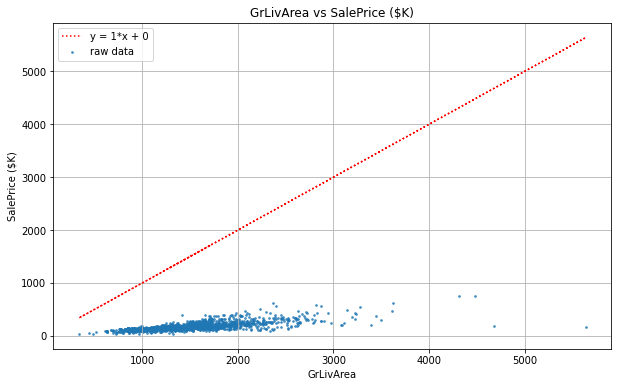

In [16]:
## Combine into function
def evaluate_model(X,y,slope,intercept, show=False, plot=False):
    ## Make a dictionary to collect results
    res = {}

    ## Calculate RSS
    res['RSS'] = round(residual_sum_squares(X,y,slope,intercept),2)
    ## Calculate RMSE
    res['RMSE'] = round(root_mean_squared_error(X,y,slope,intercept),2)

    ## Calculate R2
    y_pred = regression_model(X,slope,intercept)
    res['R2'] = round(r2_score(y,y_pred),2)

    ## Add optional print statement
    if show:
        [print(f"{k} = {v}") for k,v in res.items()]
    
    ## Add Optional Plot using plotting code from above 
    if plot:
        ## Plot Raw Data
        fig,ax = scatter_plot(X,y)

        ## Plot Predicted Values
        ax.plot(X,y_pred,c='red',ls=':', label = regression_formula(slope,intercept))
        ax.legend()
        ax.grid()
        
    ## Return the res dict and y_preds
    return res,y_pred

## Use our function below
res, _ = evaluate_model(X,y,slope,intercept,True,True)

### Moving towards gradient descent

So this will be our technique for finding our "best fit" line:

> * Choose a regression line with a guess of values for $m$ and $b$
> * Calculate the RSS
> * Adjust $m$ and $b$, as these are the only things that can vary in a single-variable regression line.
> * Again calculate the RSS 
> * Repeat this process
> * The regression line (that is, the values of $b$ and $m$) with the smallest RSS is our **best fit line**


#### Using Loss Function to Find the Optimal Value of $m$

- Let's set a fixed value for our intercept and then lets try a list of possible $m$ values and plot the cost curve

In [18]:
INTERCEPT = 0
delta_M = .01

## Generate a list of all slopes to try
slope_list = np.arange(-2, 2,delta_M)
slope_list[:10]

array([-2.  , -1.99, -1.98, -1.97, -1.96, -1.95, -1.94, -1.93, -1.92,
       -1.91])

In [19]:
## Set up a list to append the m, RSS, and R2 results for each slope
res=[['m','RSS','R2']]

## For loop trying all possible slopes
for m in slope_list:
    results, _ = evaluate_model(X,y,m,INTERCEPT)
    res.append([m,results['RSS'],results['R2']])
res

[['m', 'RSS', 'R2'],
 [-2.0, 16854658448.45, -1829.45],
 [-1.99, 16695926672.77, -1812.22],
 [-1.98, 16537946088.3, -1795.06],
 [-1.97, 16380716693.87, -1777.98],
 [-1.96, 16224238490.59, -1760.99],
 [-1.95, 16068511476.79, -1744.08],
 [-1.94, 15913535655.65, -1727.25],
 [-1.93, 15759311023.76, -1710.5],
 [-1.92, 15605837583.09, -1693.83],
 [-1.91, 15453115332.62, -1677.24],
 [-1.9, 15301144273.34, -1660.74],
 [-1.89, 15149924404.14, -1644.32],
 [-1.88, 14999455726.14, -1627.97],
 [-1.8699999999999999, 14849738238.18, -1611.72],
 [-1.8599999999999999, 14700771941.54, -1595.54],
 [-1.8499999999999999, 14552556834.26, -1579.44],
 [-1.8399999999999999, 14405092919.66, -1563.43],
 [-1.8299999999999998, 14258380194.22, -1547.49],
 [-1.8199999999999998, 14112418660.29, -1531.64],
 [-1.8099999999999998, 13967208316.11, -1515.87],
 [-1.7999999999999998, 13822749163.42, -1500.18],
 [-1.7899999999999998, 13679041200.78, -1484.57],
 [-1.7799999999999998, 13536084429.33, -1469.05],
 [-1.7699999999

In [20]:
res_df = pd.DataFrame(res[1:], columns=res[0])
res_df

,m,RSS,R2
0,-2.00,1.685466e+10,-1829.45
1,-1.99,1.669593e+10,-1812.22
2,-1.98,1.653795e+10,-1795.06
3,-1.97,1.638072e+10,-1777.98
4,-1.96,1.622424e+10,-1760.99
...,...,...,...
395,1.95,1.260951e+10,-1368.42
396,1.96,1.274750e+10,-1383.41
397,1.97,1.288624e+10,-1398.47
398,1.98,1.302573e+10,-1413.62


[Text(0, 0.5, 'RSS'),
 Text(0.5, 0, 'Slope Value'),
 Text(0.5, 1.0, 'Cost Curve for m')]

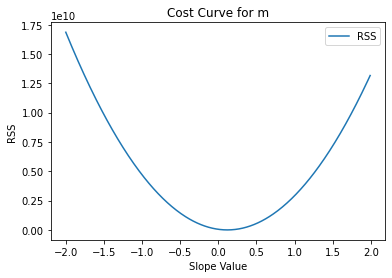

In [21]:
ax = res_df.plot('m','RSS',figsize=(6,4))
ax.set(ylabel='RSS',xlabel='Slope Value',title='Cost Curve for m')

In [22]:
res_df.sort_values('RSS').head()

,m,RSS,R2
212,0.12,4652172.76,0.49
211,0.11,4882720.45,0.47
213,0.13,5172815.18,0.44
210,0.10,5864459.31,0.36
214,0.14,6444648.90,0.30


In [23]:
best_m = 0.12

RSS = 4652172.76
RMSE = 1.48
R2 = 0.49


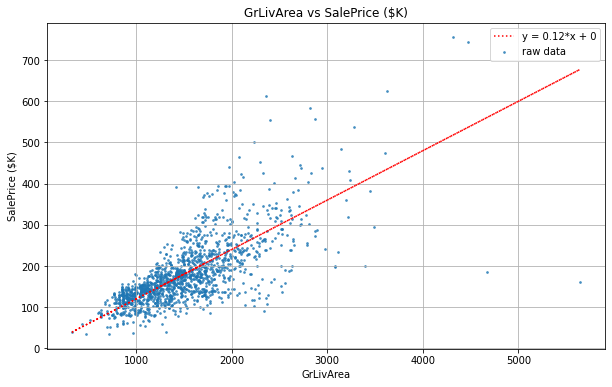

In [24]:
## Use Best Slope to get final model result using evaluate_model
evaluate_model(X,y,best_m,INTERCEPT,True,True);

> The bottom of the blue curve displays the $m$ value that produces the lowest RSS.

> - ***So why can't we try every possible option all the time? Why can't we just test out every possible value and find the value that minimizes our loss function?***

> - ***Because our equations will get more complex and  we will be dealing with more than 1 variable to optimize***

## Gradient Descent to Find Optimal Parameters - Step Size

### The slope of the cost curve tells us our step size

- **The sign (+/-) of the slope indicates if we are approaching the minimum**
    * If the slope tilts downwards, then we should walk forward to approach the minimum.  
    * And if the slope tilts upwards, then we should point walk backwards to approach the minimum.  
* **The steeper the tilt, the further away we are from our cost curve's minimum, so we should take a larger step.**

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-gradient-descent-step-sizes-online-ds-ft-100719/master/images/snowboard.png" width=60%>


## Step Size

* We **cannot** simply use the derivative to find the minimum.  Using that approach will be impossible in many scenarios as our regression lines become more complicated.

* We **cannot** alter all of the variables of our regression line across all points and calculate the result.  It will take too much time, as we have more variables to alter. 


> Let's call each of these changes a **step**, and the size of the change our **step size**. 

Our new task is to find step sizes that bring us to the best RSS quickly without overshooting the mark.

- True Gradient Descent doesn't just try a fixed number of evenly spaced values.
- It uses the size of the slope to indicated **how much** the parameter should change (the **step size**).
- We use a parameter called the **learning rate** to control how rapidly we update the parameter.


## Updating our slope


- **We use the following procedure to find the ideal $m$:**

$$\large m_i = m_{i-1} - \text{LR}* Loss_{m_i}$$

- $m_i$ = Updated slope value for the model. 
- $m_{i-1}$ = the model's prior slope value

- LR represents the Learning Rate
    - A decimal between 0 and 1 (usually)
- $Cost_{m_i}$ = current slope value from cost function's derivative.

> Lesson's Version: <br>"Update $m$ with the formula $ m = (-.02) * slope_{m = i} + m_i$."





## Activity: Gradient Descent Step Sizes Lab

- **Notebook:** `fsds_pt_100719_cohort_notes/labs_from_class/sect_23_derivatives/sect_23_gradient_descent_step_size_lab_SG.ipynb`

- **Lesson**:
    - https://learn.co/tracks/module-3-data-science-career-2-1/machine-learning/section-23-calculus/gradient-descent-step-sizes

### Learning Rate

1. A small learning rate requires many updates before reaching the minimum 
2. The optimal learning rate quickly converges to the minimum point 
3. A learning rate that is too large leads to divergent behavior: you may bounce around the minimum!  

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-lp-gradient-descent/master/images/learning_rates.png" width=70%>

### Gradient Descent with RSS as a Multivariate Equation


- Cost Function $J$ (RSS):

$$ \large RSS =  \sum_{i=1}^n(y_i - \hat{y})^2 $$ 

$$ \large J(m, b) = \sum_{i=1}^{n}(y_i - \hat{y})^2 $$

- we know $\hat{y} = mx + b$, so: 

$$ J(m, b) = \sum_{i=1}^{n}(y_i - (mx_i + b))^2 $$




- Examine our cost curve once it includes both $m$ and $b$

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-gradient-descent-step-sizes-online-ds-pt-100719/master/images/new_gradientdescent.png" width=70%>

___

# 🗓 Section 23 - Pt3: Gradient Descent in 3D
- 03/18/20

## Questions?


- 

## Learning Objectives

- ~~Review how we can use derivatives to find minima/maxima~~
- ~~Introduce the terminology of Cost/Loss functions~~
- ~~Attempt to guess a linear regression model on our own using derivatives, but without gradient descent.~~
- ~~Learn what gradient descent is and what step sizes are.~~
- ~~Activity: Step Sizes Lab.~~
- Define what a gradient really is in multiple dimensions.
- Demonstrate Gradient Descent using a Linear Regression model with Residual Sum of Squares.
- **Activity: Applying Gradient Descent Lab**

## Gradient Descent in 3D

- Gradient Descent in 3D will involve tuning multiple parameters simultaneously.

- A 3D Gradient ($\nabla$) uses **partial derivatives** test the best direction and magnitude to adjust both $m$ and $b$ .

$$ \large \nabla J(m, b) = \frac{\delta J}{\delta m}, \frac{\delta J}{\delta b}$$
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-gradient-descent-step-sizes-online-ds-pt-100719/master/images/new_gradientdescent.png" width=70%>


<!---#### Gradient Descent - Standing on a Rock

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-gradient-descent-in-3d-online-ds-ft-100719/master/images/traveller-stepping.jpg" width=100%>

> So how does this approach of shifting back and forth translate mathematically?  It means we determine the slope in one dimension, then the other. Then, we move where that slope is steepest downwards.  This moves us towards our minimum.

--->

#### Gradient Descent Upside Down: Mountain Climbing

<img src="https://raw.githubusercontent.com/learn-co-students/dsc-the-gradient-in-gradient-descent-online-ds-ft-100719/master/images/Denali.jpg">


> Here, in finding gradient ascent, our task is not to calculate the gain from a move in either the $x$ or $y$ direction.  Instead, our task is to **find some combination of a change in $x$,$y$ that brings the largest change in output**.  


- Our function $f(x,y)$ represents the movement of the climbers towards the summit.

- So $\nabla f(x, y) = \frac{\delta f}{\delta y}, \frac{\delta f}{\delta x} $.  

<!---
- This means that to take the path of greatest ascent, you should move $ \frac{\delta f}{\delta y} $ divided by $ \frac{\delta f}{\delta x} $.  


- So for example, when $ \frac{\delta f}{\delta y}f(x, y)  = 3 $ , and $ \frac{\delta f}{\delta x}f(x, y)  = 2$, you traveled in line with a slope of 3/2.

- For gradient descent, that is to find the direction of greatest decrease, you simply reverse the direction of your partial derivatives and move in $ - \frac{\delta f}{\delta y}, - \frac{\delta f}{\delta x}$. --->

### Gradient Descent with Linear Regression

$$ 
\begin{align}
RSS &= \sum_{i=1}^n(actual - expected)^2 \\
&= \sum_{i=1}^n(y_i - \hat{y})^2 \\
&= \sum_{i=1}^n(y_i - (mx_i + b))^2
\end{align}
$$ 

#### Update Rule:


### Equation for Calculating RSS Partial Derivatives

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-gradient-descent-step-sizes-online-ds-pt-100719/master/images/new_gradientdescent.png" width=40%>

$$ \large J(m, b)= \sum_{i=1}^n(y_i - (mx_i + b))^2 $$

As we know, the gradient of a function is simply the partial derivatives with respect to each of the variables, so:

$$ \large \nabla J(m, b) = \frac{\delta J}{\delta m}, \frac{\delta J}{\delta b}$$


$$
\begin{align}
\frac{\delta J}{\delta m}J(m, b) & = \boldsymbol{\frac{\delta J}{\delta m}}(y - (mx + b))^2  &&\text{partial derivative with respect to} \textbf{ m}\\
\\
\frac{\delta J}{\delta b}J(m, b) & = \boldsymbol{\frac{\delta J}{\delta b}}(y - (mx + b))^2  &&\text{partial derivative with respect to} \textbf{ b}\\
\end{align}
$$

- **The equations for the partial derivatives of our RSS function with respect to m and b are:**


$$ \frac{dJ}{dm}J(m,b) = -2\sum_{i = 1}^n x_i(y_i - (mx_i + b)) = -2\sum_{i = 1}^n x_i*\epsilon_i$$

$$  \frac{dJ}{db}J(m,b) = -2\sum_{i = 1}^n(y_i - (mx_i + b)) = -2\sum_{i = 1}^n \epsilon_i $$

- Our update rules for m and b become:
    - `current_m` = `old_m` $ -  (-2*\sum_{i=1}^n x_i*\epsilon_i )$

    - `current_b` =  `old_b` $ - ( -2*\sum_{i=1}^n \epsilon_i )$

### Note: Source of these Equations
- **These formulas are derived in one of the Appendix lessons for this section that applies the Chain Rule (also an appendix lesson)**
    - [Appendix Lesson: The Chain Rule](https://learn.co/tracks/module-3-data-science-career-2-1/appendix/more-on-derivatives/derivatives-the-chain-rule)
    - [Appendix Lesson: Gradient to Cost Function](https://learn.co/tracks/module-3-data-science-career-2-1/appendix/more-on-derivatives/gradient-to-cost-function-appendix)
    
> The chain rule says that we can represent complex equations as multiple equations, and then we can take the derivative of outer and inner equations separately.

> $$ \large F(x) = f(g(x)) $$
> $$ \large F'(x) = f'(g(x))*g'(x) $$



- **Applied to our Cost Function:**


> "In calculating the partial derivatives of our function $J(m, b) = \sum_{i=1}^{n}(y_i - (mx_i + b))^2$, **we won't change the result if we ignore the summation until the very end**." 

$$ J(m, b)= \sum_{i=1}^n(y_i - (mx_i + b))^2 $$

$$ g(m,b) = y - (mx + b)$$ 

$$ f(g(m,b))= (g(m,b))^2 $$




## Activity: Apply Gradient Descent Lab

- **Notebook:** `Mod 3>sect_23> dsc-applying-gradient-descent-lab-onl01-dtsc-pt-041320-master`

- **Lesson**:
    - https://learn.co/tracks/module-3-data-science-career-2-1/machine-learning/section-23-calculus/applying-gradient-descent-lab

___

# APPENDIX

### Partial Derivatives

$$\large f(x, y) = y*x^2 $$

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-gradient-descent-in-3d-online-ds-pt-100719/master/images/new_parabolayx2.png' width=40%/>


- To measure the slope in each dimension, one after the other, we'll take the derivative with respect to one variable, and then take the derivative with respect to another variable.  

- To take a derivative with respect to $x$ means to ask, how does the output change, as we make a nudge only in the $x$ direction. 
- To express that we are nudging in the $x$ direction we say $\frac{\delta f}{\delta x}$. 
    - We fill in a constant for the value of y (the current value) and then take the derivative with respect to x. 

-  To express we are nudging in the $y$ direction, we say $\frac{\delta f}{\delta y}$. 
    - We fill in a constant for the value of x and then take the derivative with respect to y


So what does a derivative $\frac{\delta f}{\delta x}$ look like? How do we think of a partial derivative of a multivariable function?

Well, remember how we think of a standard derivative of a one variable function, for example $f(x) = x^2 $. 

$\frac{df}{dy}f(x, y)$ where $f(x,y) = (yx^2) $.  

## Gradient Descent Notation

#### Generalized Gradient Descent  Math Notation

- In the below equations: 
     - x and x_i represent whatever paramater is being tested and updated. 
     
 
- Multi-dimensional version of a derivative 
$$-\nabla = \sum_i \dfrac{\partial}{\partial x_i}$$

$$ x_{i+1} = x_i - \eta * f'(x_i)$$


- When minimum is reached, $ \eta *f'(x_i) $ becomes 0. 
$$ x_{i+1} = x_i - 0 $$
